In [22]:
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyabf
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
from sklearn.cluster import KMeans
from sklearn import metrics
from glob import glob
from sklearn.metrics import r2_score, explained_variance_score

from figure2_func import extract_paired, decay_func, get_ifr, filter_data, peak_finding, fit_decay_curve



In [27]:
# all_d = glob('../../data/2_CrayfishMRO/better_data/*.abf')
# for tmp_p in all_d:
#     tmp_d = extract_paired(tmp_p)
#     print(tmp_p)
#     plt.scatter(tmp_d['times'], tmp_d['ch1'])
#     plt.show()




#norm
#21929034
#21929037

In [141]:
data_path = '../../data/2_CrayfishMRO/better_data/21929037.abf'


In [142]:

data = extract_paired(data_path)
 
#     return {'nerve_data':nerve_v,
#             'muscle_data':muscle_v,
#             'times':times,
#             'misc':data_tmp,
#            }

<Figure size 640x480 with 0 Axes>

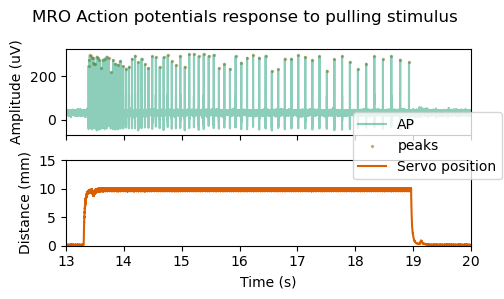

In [145]:
plt.style.use('default')
plt.set_cmap('Dark2')
colors = plt.cm.Dark2(np.linspace(0, 1, 10))

non_edge_peaks, peak_heights = peak_finding (data['ch1'], [133000,190000])
fig, axes = plt.subplots(2,1, sharex=True, figsize=(5,3))

plt.suptitle('MRO Action potentials response to pulling stimulus')

axes[0].plot(data['times'], data['ch1'], alpha=.5, label ='AP', color=colors[1])
axes[0].scatter(data['times'][non_edge_peaks], 
                data['ch1'][non_edge_peaks], 
                s=2, alpha=.5, label ='peaks',color=colors[7])
axes[0].set_xlim(13,20)
axes[0].set_ylabel('Amplitude (uV)')

#axes0.scatter(times[peaks], nerve_data[peaks], color=[colors[c] for c in k_labels])
#axes1 = axes0.twinx()
axes[1].plot(data['times'], data['ch2'], label ='Servo position', color=colors[2])
axes[1].set_ylabel('Distance (mm)')
axes[1].set_xlabel('Time (s)')

axes[1].set_xlim(13,20)
axes[1].set_ylim(0,15)

fig.legend(loc=(.7,.4))
plt.tight_layout()

In [86]:
fit_param, curve_data, perr = fit_decay_curve(non_edge_peaks, data['times'])

r2_score(curve_data[1], decay_func(curve_data[0],*fit_param))
explained_variance_score(curve_data[1], decay_func(curve_data[0],*fit_param))

0.9562110311888105

In [106]:
# get firing freq & timestamps
ifr_val = get_ifr(data['times'][non_edge_peaks])
ifr_times = np.convolve(data['times'][non_edge_peaks], np.ones(2), 'valid') / 2


#decay curve data, only from peak forward
ifr_peak = np.argmax(ifr_val)
decay_data = ifr_val[ifr_peak:]
decay_times = ifr_times[ifr_peak:]

#remove edge outliers
ok_decay_ids = np.where(np.diff(decay_data)<10)[0]
decay_data = decay_data[ok_decay_ids]
decay_times = decay_times[ok_decay_ids]

# shift decay times to start w 0
decay_times_shift = decay_times - decay_times[0]

_, smoothed_decay_data = filter_data(decay_data, kernel_size=7)

smooth_peak = np.argmax(smoothed_decay_data)
smoothed_decay_data = smoothed_decay_data[smooth_peak:]
decay_times_shift = decay_times_shift[smooth_peak:]
fit_param, pcov = curve_fit(decay_func, decay_times_shift, smoothed_decay_data, (smoothed_decay_data[0],.5,smoothed_decay_data[-1]))
    
    

In [121]:
len(smoothed_decay_data)

68

<Figure size 640x480 with 0 Axes>

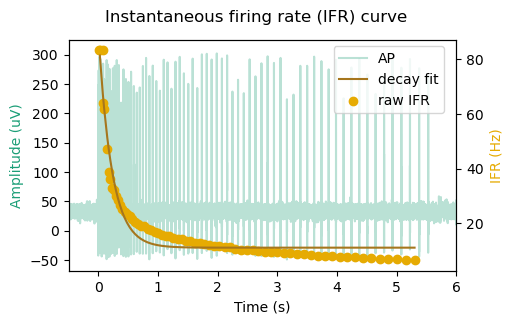

In [150]:

plt.style.use('seaborn-colorblind')
plt.set_cmap('Dark2')
fig, axes = plt.subplots(figsize=(5,3))

plt.suptitle('Instantaneous firing rate (IFR) curve')

axes.plot(data['times']-decay_times[0], data['ch1'], alpha=.3, label='AP', color=colors[1])
axes.set_xlim(-.5,6)
#axes1.legend()
axes.set_ylabel('Amplitude (uV)', color=colors[1])
axes1 = axes.twinx()
axes1.scatter(decay_times_shift, smoothed_decay_data, label='raw IFR', color=colors[6])
axes1.plot(decay_times_shift[1:], decay_func(decay_times_shift[1:],*fit_param), label='decay fit', color=colors[7])




axes1.set_ylabel('IFR (Hz)', color=colors[6])
axes.set_xlabel('Time (s)')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,loc=(.65,.65))

plt.show()
